# Load Data

In [1]:
import dataloader
import pandas as pd
import numpy as np
from tensorflow import keras
from keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import seaborn as sns
import os
from tqdm.notebook import tqdm

sid = '08db4255286f'

In [2]:
data = dataloader.load_sid(sid)

In [3]:
data.sample(5)

,series_id,step,timestamp,anglez,enmo,activity
271827,08db4255286f,271827,2018-11-21 07:32:15+00:00,-43.038300,0.0151,Sleeping
376045,08db4255286f,376045,2018-11-27 08:17:05+00:00,-44.578701,0.0029,Sleeping
222492,08db4255286f,222492,2018-11-18 11:01:00+00:00,-71.014702,0.0003,Sleeping
143102,08db4255286f,143102,2018-11-13 20:45:10+00:00,-4.050100,0.4043,Waking
49774,08db4255286f,49774,2018-11-08 11:07:50+00:00,-41.876598,0.0107,Waking


In [4]:
padding_minutes = 5
padding = padding_minutes*12 # 1 minute is 12 steps
angle_window = dataloader.windows(data, 'anglez', padding).dropna()
enmo_window  = dataloader.windows(data, 'enmo', padding).dropna()

In [5]:
print(f"""
angles shape: {angle_window.shape}
enmos shape:  {enmo_window.shape}""")


angles shape: (440160, 121)
enmos shape:  (440160, 121)


In [6]:
# np.concatenate([angle_window.to_numpy(),enmo_window.to_numpy()], axis=1).shape
X = np.stack([angle_window.to_numpy(), enmo_window.to_numpy()], axis=1)
Y = (data.loc[angle_window.index, 'activity']=='Sleeping').astype(int).to_numpy()
X.shape, Y.shape

((440160, 2, 121), (440160,))

In [7]:
from sklearn.utils import shuffle
day = 24*60*12 # 24hours * 60Minutes * 12Steps
x_train, y_train = shuffle(X[:-day], Y[:-day], random_state=42)
x_test, y_test = X[-day:], Y[-day:]
for i in [x_train, y_train, x_test, y_test]:
    print(i.shape)

(422880, 2, 121)
(422880,)
(17280, 2, 121)
(17280,)


# Model

In [8]:
checkpoint_file = os.path.join('training_checkpoints', 'cp.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_file)

train_model = not os.path.exists(os.path.join('training_checkpoints', 'checkpoint'))
train_model

False

In [9]:
model = keras.Sequential(layers=[
    layers.Conv2D(32, (2, 50), input_shape = (*x_train.shape[-2:],1), activation='relu'),
    layers.MaxPool2D((1,8)),
    layers.Flatten(),
    layers.Dense(10, activation='relu'),
    layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 72, 32)         3232      
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 9, 32)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 10)                2890      
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 6144 (24.00 KB)
Trainable params: 6144 (24.00 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

# Training

In [10]:
if train_model:
    model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
        jit_compile=True
    )

In [11]:
if train_model:
    cp_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_file,
        save_weights_only=True,
        verbose=1
    )

    history = model.fit(
        x_train,
        y_train,
        epochs=10,
        validation_data=(x_test, y_test),
        callbacks=[cp_callback]
    )

In [12]:
if train_model:
    hist = pd.DataFrame(history.history)
else:
    hist = pd.read_csv(os.path.join('logs', 'history.csv'), sep='\t')
hist

,loss,accuracy,val_loss,val_accuracy
0,0.364577,0.854857,0.495668,0.845197
1,0.327361,0.873600,0.479594,0.839063
2,0.303752,0.881903,0.503609,0.853819
3,0.283026,0.887609,0.397347,0.905208
4,0.271046,0.890671,0.509542,0.901215
5,0.261270,0.894710,0.435928,0.910822
6,0.252627,0.898023,0.432855,0.887500
7,0.246040,0.900906,0.471087,0.897222
8,0.241144,0.902604,0.580836,0.895139
9,0.237027,0.904403,0.503394,0.904688


Text(0.5, 1.0, 'Loss in training')

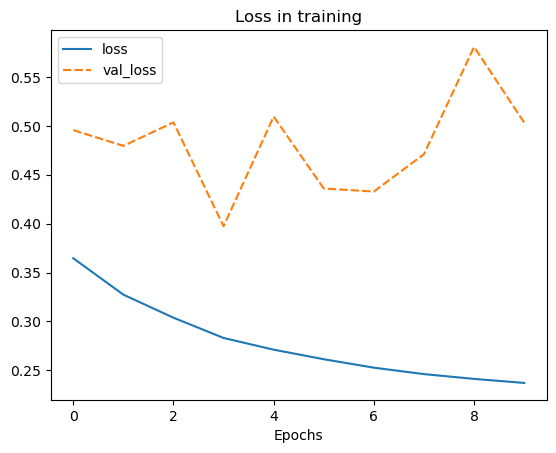

In [13]:
ax = sns.lineplot(hist[['loss', 'val_loss']])
ax.set_xlabel("Epochs")
ax.set_title("Loss in training")

Text(0.5, 1.0, 'Accuracy in Training')

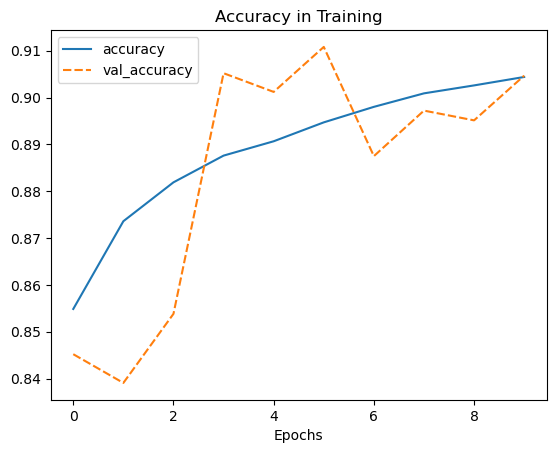

In [14]:
ax = sns.lineplot(hist[['accuracy', 'val_accuracy']])
ax.set_xlabel("Epochs")
ax.set_title("Accuracy in Training")

# Evaluate

In [15]:
model.load_weights(checkpoint_file)

In [16]:
y_res = model(x_test)
y_res.shape

TensorShape([17280, 2])

In [17]:
predictions = pd.Series(y_res[:,1], index=data.loc[data.index[-day:], 'timestamp'])
truths = pd.Series(y_test, index=data.loc[data.index[-day:], 'timestamp'])

In [18]:
def plot_preds(ax, preds: pd.Series, truths, thresh, pred_label='Predictions',flipped=False):
    ax.clear()
    # ax.set_title(f"Predictions by threshold: {round(thresh,2)}")
    if truths is not None:
        xy = (truths, truths.index) if flipped else (truths.index, truths)
        ax.plot(*xy, label='True value')

    xy = (preds, preds.index) if flipped else (preds.index, preds)
    ax.plot(*xy, ',', label=pred_label)
    f = ax.axvline if flipped else ax.axhline
    f(thresh, linewidth=0.25)
    ax.legend()
    tim_lab, slp_lab = (ax.set_ylabel, ax.set_xlabel) if flipped else (ax.set_xlabel, ax.set_ylabel)
    tim_lab('Time')
    slp_lab('Sleeping')

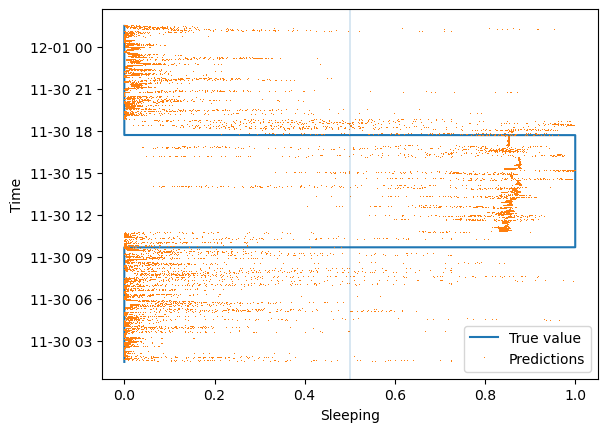

In [19]:
%matplotlib inline
fig, ax = plt.subplots()
plot_preds(ax,predictions,truths,0.5, flipped=True)

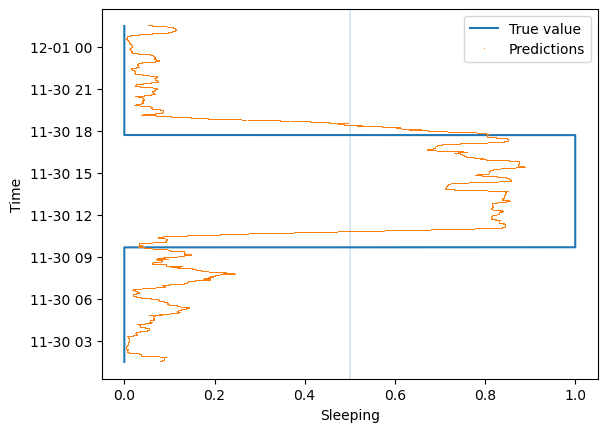

In [20]:
%matplotlib inline
fig, ax = plt.subplots()
n = padding*7
thresh = 0.5
conv1 = pd.Series(np.convolve(predictions, [1./n]*n, "same"), predictions.index)
# conv1 = pd.Series(conv1, index=predictions.index)
plot_preds(ax, conv1, truths, thresh, flipped=True)

In [21]:
%matplotlib qt
fig, ax = plt.subplots()
conv_minutes = [1./12, 5, 10, 20, 30, 60, 2*60, 4*60, 6*60, 10*60]

def draw(cm):
    ax.clear()
    steps = round(cm*12)
    conv1=pd.Series(np.convolve(predictions, [1./steps]*steps, "same"),predictions.index)
    plot_preds(ax, conv1, truths, thresh)
    duration = f"{cm} minutes" if cm < 60 else f"{cm/60} hours"
    title = f"Convolution of {duration}"
    if steps == 1:
        title = "No Convolution"
    ax.set_title(title)

# draw(conv_minutes[0])
anime = anim.FuncAnimation(
    fig,
    draw,
    tqdm(conv_minutes),
    interval=500
)
plt.show()
# anime.save(os.path.join('vids','conv_sizes.mp4'))


  0%|          | 0/10 [00:00<?, ?it/s]

# Visualizing predictions on another child

In [22]:
# dataloader.init()

In [23]:
sid2 = "0a96f4993bd7"

In [24]:
child2 = dataloader.load_sid(sid2)

In [25]:
child2.sample(5)

,series_id,step,timestamp,anglez,enmo,activity
70958,0a96f4993bd7,70958,2018-05-07 17:03:10+00:00,-39.223900,0.0327,Waking
52918,0a96f4993bd7,52918,2018-05-06 15:59:50+00:00,63.927502,0.0317,Waking
239279,0a96f4993bd7,239279,2018-05-17 10:49:55+00:00,34.818699,0.0000,Sleeping
123434,0a96f4993bd7,123434,2018-05-10 17:56:10+00:00,15.388800,0.4814,Waking
185258,0a96f4993bd7,185258,2018-05-14 07:48:10+00:00,35.544399,0.0011,Sleeping


In [26]:
angle2_window = dataloader.windows(child2, 'anglez', padding).dropna()
enmo2_window  = dataloader.windows(child2, 'enmo', padding).dropna()

In [27]:
X = np.stack([angle2_window.to_numpy(), enmo2_window.to_numpy()], axis=1)
X.shape

(256740, 2, 121)

In [28]:
Y = (child2.loc[angle2_window.index, 'activity']=='Sleeping').astype(int)
Y.index = child2.loc[Y.index, 'timestamp']

In [29]:
Y.shape

(256740,)

In [30]:
y = pd.Series(model(X)[:,1], Y.index)

In [31]:
y.shape, Y.shape

((256740,), (256740,))

Text(0.5, 1.0, 'model trained of 08db4255286f predicting for 0a96f4993bd7')

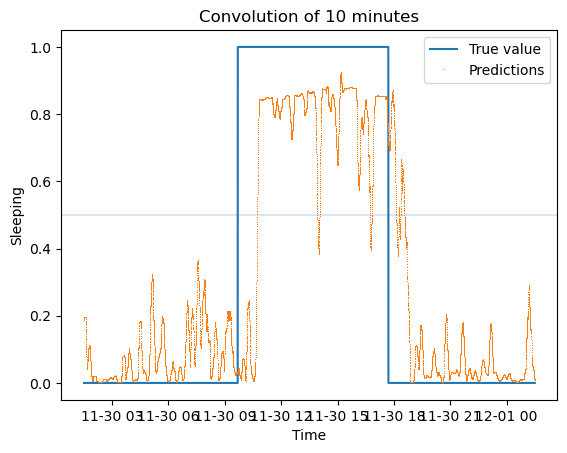

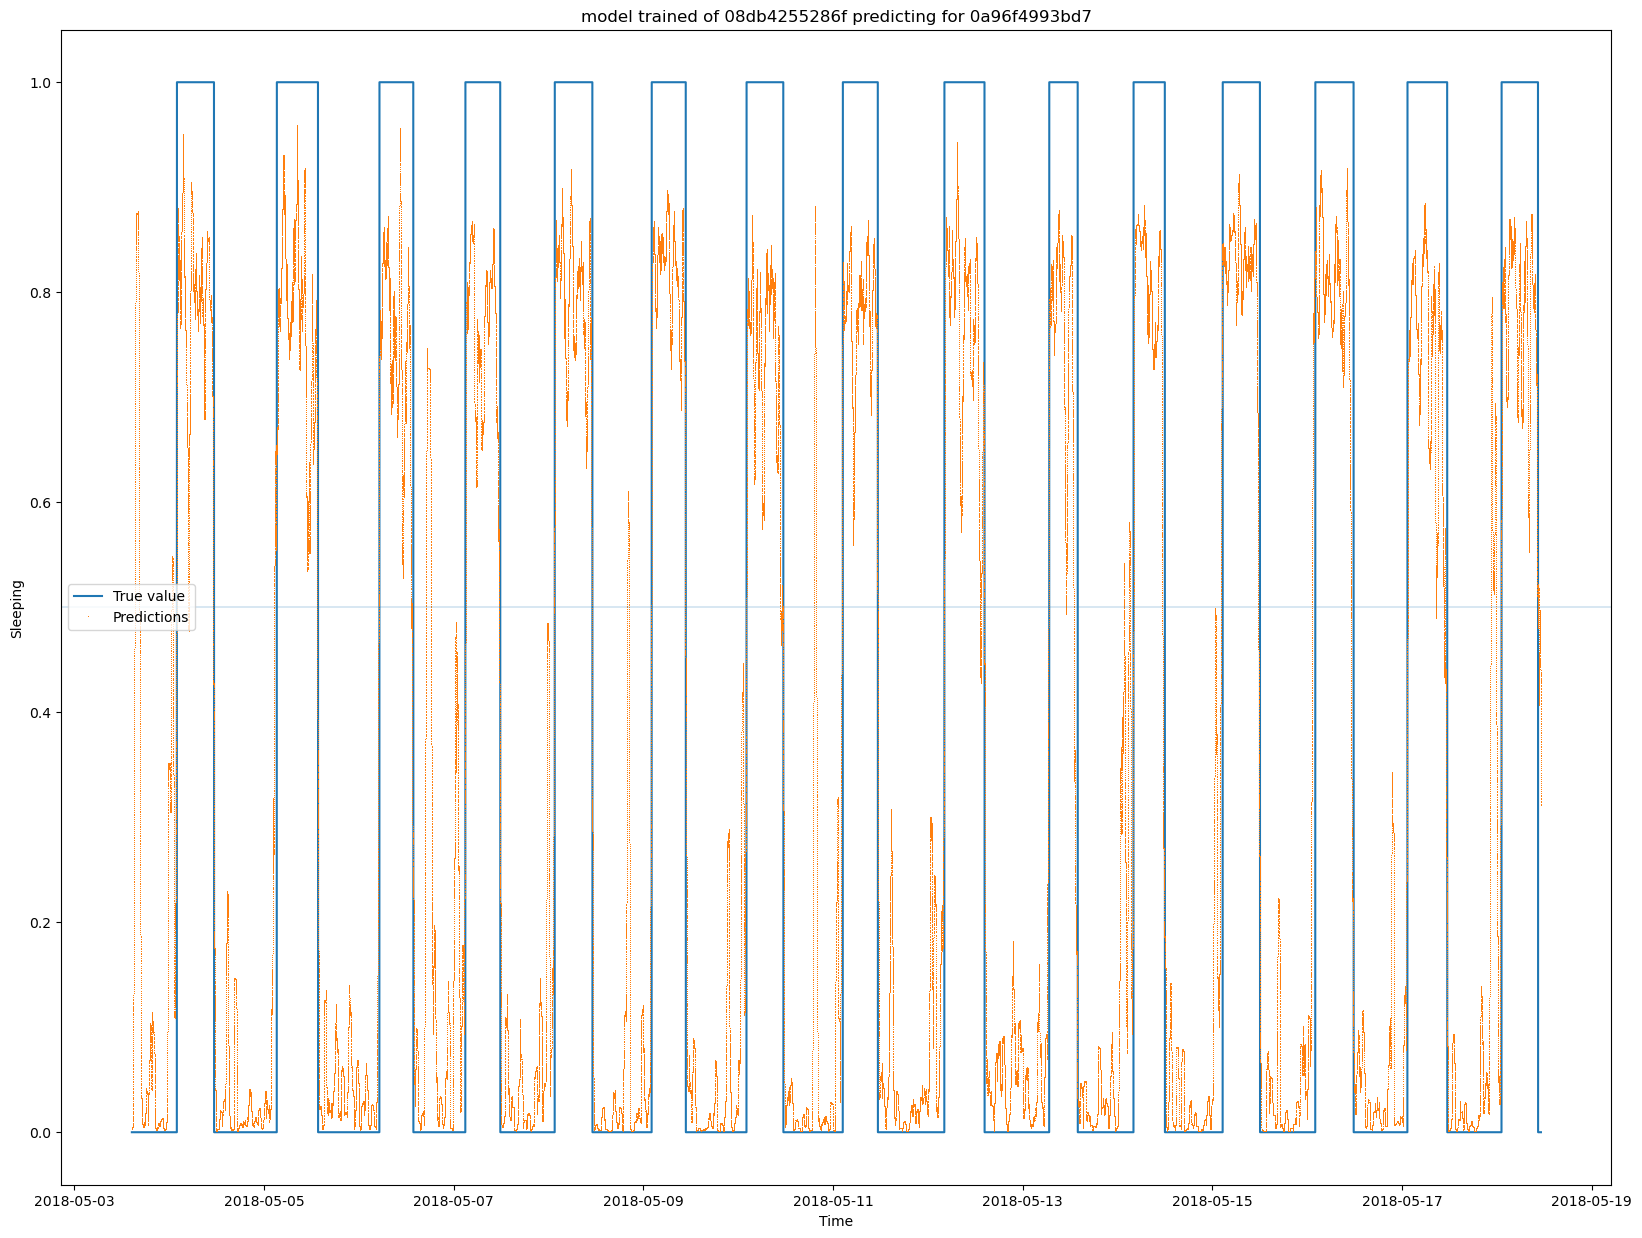

In [32]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
n = 40*12
conv1 = pd.Series(np.convolve(y, [1./n]*n,"same"), y.index)
plot_preds(ax, conv1, Y, 0.5)
ax.set_title(f"model trained of {sid} predicting for {sid2}")

In [33]:
%matplotlib qt
fig, ax = plt.subplots()
n = 40*12
conv1 = pd.Series(np.convolve(y, [1./n]*n,"same"), y.index)
plt.suptitle(f"Model prediction convolved over {round(n/12)} minutes")
def draw(ts):
    ax.clear()
    y_ = conv1.loc[((conv1.index>=ts) & (conv1.index<ts+pd.Timedelta(1,'day')))]
    Y_ = Y.loc[((Y.index>=ts) & (Y.index<ts+pd.Timedelta(1,'day')))]
    plot_preds(ax, y_, Y_, 0.5, flipped=True)

anime = anim.FuncAnimation(
    fig,
    draw,
    tqdm(y.index[::1000]),
    # interval=1
)
anime.save(os.path.join("vids",f"full_pred_conv_{round(n/12)}_min.mp4"))

  0%|          | 0/257 [00:00<?, ?it/s]